In [15]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from IPython.display import Latex
from datetime import datetime

import nbimporter
import spin_func as myfunc
from importlib import reload
reload(myfunc)

<module 'spin_func' from 'spin_func.ipynb'>

In [16]:
##########################
### System Hamiltonian ###
##########################

m = 3; n = 1; B = [0, 0, 1.6]; A = [[50], [100], [150]];
H_zn = Qobj(myfunc.z_hamiltonian(m, 0, B)) # Hz
H_ze = Qobj(np.kron(np.eye(2**m), myfunc.z_hamiltonian(0, n, B)))
H_hf = Qobj(myfunc.hf_hamiltonian(m, n, A))

H_neut = Qobj(np.kron(H_zn, np.eye(2**n)))+H_ze+H_hf
H_ion = H_zn

spinProj = Qobj(np.kron(np.eye(2**m), np.eye(2**n+1)[0:2**n]))
setProj = Qobj(np.kron(np.eye(2**m), np.eye(2**n+1)[-1]))

H = Qobj(spinProj.dag()*H_neut*spinProj+setProj.dag()*H_ion*setProj)

H_new = Qobj(np.diag(H.eigenstates()[0]))
evecs = H.eigenstates()[1]
l = len(np.diag(H.eigenstates()[0]))

In [17]:
############################
### Projection Operators ###
############################

basisT = Qobj(np.concatenate(([np.array(evecs[i]) for i in range(len(evecs))]), axis = 1))

state0 = Qobj(np.kron(fock_dm(2**m, 0), np.eye(2**n+1)))
state1 = Qobj(np.kron(fock_dm(2**m, 1), np.eye(2**n+1)))
state2 = Qobj(np.kron(fock_dm(2**m, 2), np.eye(2**n+1)))
state3 = Qobj(np.kron(fock_dm(2**m, 3), np.eye(2**n+1)))
state4 = Qobj(np.kron(fock_dm(2**m, 4), np.eye(2**n+1)))
state5 = Qobj(np.kron(fock_dm(2**m, 5), np.eye(2**n+1)))
state6 = Qobj(np.kron(fock_dm(2**m, 6), np.eye(2**n+1)))
state7 = Qobj(np.kron(fock_dm(2**m, 7), np.eye(2**n+1)))

electron_up = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 0)))
electron_down = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 1)))
electron_set = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 2)))

### Expressed in Eigenbasis ###

state0  = basisT.dag()*state0*basisT
state1  = basisT.dag()*state1*basisT
state2  = basisT.dag()*state2*basisT
state3  = basisT.dag()*state3*basisT
state4  = basisT.dag()*state4*basisT
state5  = basisT.dag()*state5*basisT
state6  = basisT.dag()*state6*basisT
state7  = basisT.dag()*state7*basisT

electron_up = basisT.dag()*electron_up*basisT
electron_down = basisT.dag()*electron_down*basisT
electron_set = basisT.dag()*electron_set*basisT

In [18]:
#######################
### Tunneling Times ###
#######################

set2down = basisT.dag()*Qobj(np.kron(np.eye(2**m), fock(3, 1)*fock(3, 2).dag()))*basisT

tauRead_up_out = 80e-6
tauRead_down_in = 120e-6

Lread_down_in = np.sqrt(1/tauRead_down_in)*set2down
emptyOpt = 0
tauRead = [tauRead_up_out]
Lread = myfunc.outOp(m, evecs, tauRead, emptyOpt)
Lread.append(Lread_down_in)
LiouRead = liouvillian(2*np.pi*H_new, Lread)

In [19]:
######################
### Time Evolution ###
######################

T = 1e-3
dt = 1e-6
N = int(T/dt)
t = np.arange(0, T, dt)

rho_init = basisT.dag()*fock_dm(24, 0)*basisT
rho_vec = operator_to_vector(rho_init)
rho = []

expLiouRead = ((dt*LiouRead).expm())
for i in range(N):
    rho_vec = expLiouRead*rho_vec
    rho.append(vector_to_operator(rho_vec))

config0 = np.real(expect(state0, rho))
config1 = np.real(expect(state1, rho))
config2 = np.real(expect(state2, rho))
config3 = np.real(expect(state3, rho))
config4 = np.real(expect(state4, rho))
config5 = np.real(expect(state5, rho))
config6 = np.real(expect(state6, rho))
config7 = np.real(expect(state7, rho))
eSpin_up = np.real(expect(electron_up, rho))
eSpin_down = np.real(expect(electron_down, rho))
eSET = np.real(expect(electron_set, rho))

print('Finished')
print(config0[-1])
print(config1[-1])
print(config2[-1])
print(config3[-1])
print(config4[-1])
print(config5[-1])
print(config6[-1])
print(config7[-1])

Finished
0.9999913037297045
5.569721445940451e-06
2.4900568603930304e-06
6.881789832164631e-12
6.21998447666299e-07
1.7180026421910978e-12
7.676125724379138e-13
0.0


In [20]:
t = [1000*t[i] for i in range(N)]

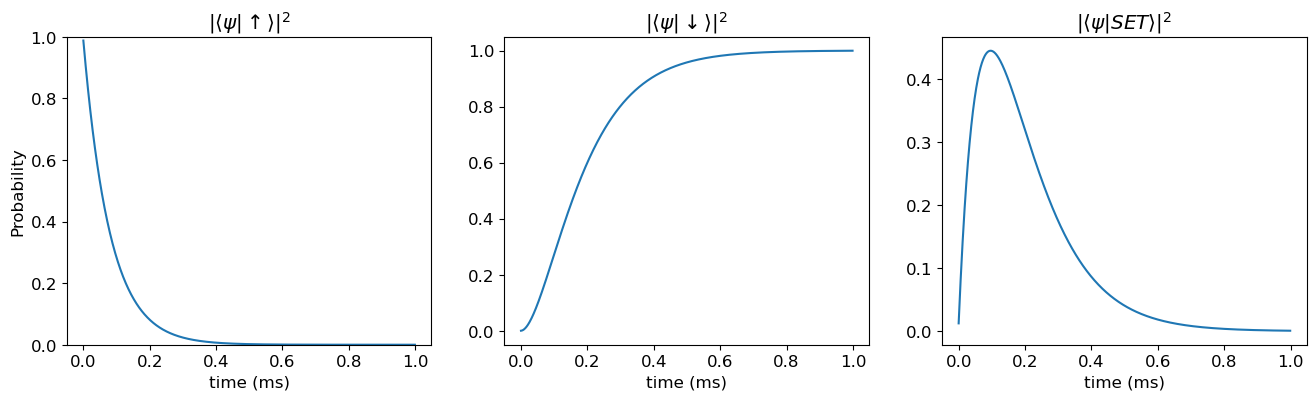

In [22]:
plt.subplot(1, 3, 2)
plt.plot(t, eSpin_down)
plt.title('$|\\langle \psi | \\downarrow \\rangle|^2$')
plt.xlabel('time (ms)')
#plt.ylabel('Probability')
plt.subplot(1, 3, 1)
plt.plot(t, eSpin_up)
plt.title('$|\\langle \psi | \\uparrow \\rangle|^2$')
plt.xlabel('time (ms)')
plt.ylabel('Probability')
plt.ylim([0, 1])
plt.subplot(1,3, 3)
plt.plot(t, eSET)
#plt.title('$|\\langle \psi | SET \\rangle|^2$')
plt.title('$|\\langle \psi | SET \\rangle|^2$')
plt.xlabel('time (ms)')
#plt.ylabel('Probability')
plt.rcParams["figure.figsize"] = (16, 4)